# Qiskit Nature

This module of qiskit is made for dealing with problems related to natural science, specially in quantum chemistry.

In general, the application is split into Problems and solvers, straightforward it works as
`result = solver.solve(problem)`

Today we are looking for the Electronic structure problem. this problem takes a ElectronicStructuredDriver, we need it to represent the problem into classical code. From that we have de GroupedElectronicProperties, such as Hamiltonian, dipole moment operators, number of particles, angular momentum and more!.

### Electronic Structure

The Hamiltonian that describes the interaction between electrons is
$$H = \sum_{p} \left(-\frac{1}{2}\nabla^2_p - \sum_{k}\frac{Z_k}{r_{pk}}\right) + \sum{q<p} \frac{1}{r_{pq}}$$

The first term is the kinetic energy of the electron, the second, is the potential depenting on the number of positive ions in the atomic structure, the last term represents the coulomb repulsion between electrons.

To find the eigenvalue of the Hamiltonian $H$ we have to solve
$$H|\psi_n\rangle = E_n|\psi_n\rangle.$$

Whose ground state energy is given by
$$E_0 = \frac{\langle H \rangle_{n = 0}}{\langle \psi_0|\psi_0 \rangle}$$

where $|\psi_0 \rangle$ is the ground state of the system.

### Second Quantization

The Hamiltonian is described in terms of the annihilation and creation operators $a_p$ and $a_p^\dagger$ respectively.

$$H = \sum_{pq}h_{pq}a_p^\dagger a_p + \frac{1}{2}\sum_{pqrs}g_{pqrs}a_p^\dagger a_q^\dagger a_r a_s$$

Here $h_pq$ represents the kinetic energy and the potential in which the electron is located, produces from the atomic nuclei. $g_{pqrs}$ represents the interchange terms, which describe the interaction between the electrons in the atomic structure. This two terms are non also as the 1-body and 2-body integrals.

This representation of the problem allows the wave function to be represented as an ocupation number vector, this means that we only have to find the number of electrons that are occupying determined state. That depends on the number od electrons that are in the structure.

### The `ElectronicStructureProblem`

In [30]:
import warnings
from h5py.h5py_warnings import H5pyDeprecationWarning
warnings.filterwarnings(action="ignore", category=H5pyDeprecationWarning)

In [2]:
from qiskit_nature.drivers import Molecule

molecule = Molecule(
    ### Coordinates are given in Amstrongs
    ## This is a H_2O Molecule 
    geometry =[
        ["O",[0.0, 0.0, 0.115]],
        ["H",[0.0, 0.754, -0.459]],
        ["H",[0.0, -0.754, -0.459]],
    ],
    multiplicity=1, # = 2*spin + 1
    charge=0,
)

In [32]:
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

driver = ElectronicStructureMoleculeDriver(
    molecule = molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

Now we wrap the driver into the Electronic Structure Problem as follows

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver)

Now we can inspect the Hamiltonian of the system in its second-quantized form:

In [5]:
## this will call driver.run() internally
second_q_ops = problem.second_q_ops()

In [6]:
hamiltonian = second_q_ops[0]
print(hamiltonian)

Fermionic Operator
register length=14, number terms=1085
  (0.009448189516231434+0j) * ( +_0 +_1 -_2 -_6 )
+ (-0.001603762271306217+0j) * ( +_0 +_1 -_3 -_5 )
+ (-0.030824961500492465+0j) * ( +_0 -_1 +_2 -_6 )
+ (0.021376771984261+0j) * ( +_0 -_1 -_2 +_6 ...


This means that, the number of qubits needed to represent the ElectronicStructureProblem of a $H_2O$ molecule is 14. The notation before follows:
$$(\text{Coefficient}) * (\text{creation and annihilation operators})$$

For example the first term indicates that the coefficient $0.00945$ belongs to the sequence of annihilation and creation operators $a^\dagger_0 a^\dagger_1 a_2 a_6$.

We can also get more information from the driver:

In [7]:
print(problem.grouped_property)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 1.7.6
		Config:
			atom=O 0.0 0.0 0.115;H 0.0 0.754 -0.459;H 0.0 -0.754 -0.459
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9941038468519985
		[0, 1] = -0.23249684427278883
		[0, 2] = -5.2163097720028175e-17
		[0, 3] = -0.10305188327114599
		[0, 4] = 7.025196654967917e-17
		[0, 5] = -0.13415815779896761
		[0, 6] = -5.658849884837202e-16
		[1, 0] = 0.02678207865614997
		[1, 1] = 0.8301922072362895
		[1, 2] = 1.2131017290670206e-16
		[1, 3] = 0.5369920122052861
		[1, 4] = -3.8288312478285075e-16
		[1, 5] = 0.9038656248714041
		[1, 6] = 3.7946628470547116e-15
		[2, 0] = 5.171594375443211e-19
		[2, 1] = 2.2406236522116244e-17
		[2, 2] = -1.86039324223006e-15
		[2, 3] = 6.174543708191098e-16
		[2, 4] = 0.99

The size of the problem can be reduced by selecting a subset of orbitals to be treated with the quantum algorithm. This concept is known as active space. Here we fix some of the electronic orbitals by doing a classical pre processing. Then, we left the orbitals of interest free to be treated in a quantum computer.
Qiskit provides a generic active transformer


In [8]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_molecular_orbitals=3,
)

In [33]:
problem_reduced = ElectronicStructureProblem(driver, [transformer])
second_q_ops_reduced = problem_reduced.second_q_ops()
hamiltonian_reduced = second_q_ops_reduced[0]

In [34]:
print(hamiltonian_reduced)

Fermionic Operator
register length=6, number terms=33
  (0.03893103043275939+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.038931030432759306+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.024354547060211403+0j) * ( +_0 -_2 +_3 -_5 )
+ (-0.02435454706021139+0j) * ( +_0 -_2 -_3 +_ ...


Now we only need 6 qubits to represent the reduced problem.

In [11]:
print(problem_reduced.grouped_property_transformed)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 1.7.6
		Config:
			atom=O 0.0 0.0 0.115;H 0.0 0.754 -0.459;H 0.0 -0.754 -0.459
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9941038468519988
		[0, 1] = -0.2324968442727891
		[0, 2] = 1.5836828296554566e-16
		[0, 3] = -0.10305188327114699
		[0, 4] = 2.3591204406102167e-17
		[0, 5] = -0.13415815779896692
		[0, 6] = 6.776748101802586e-16
		[1, 0] = 0.026782078656150125
		[1, 1] = 0.8301922072362904
		[1, 2] = -8.49118318557621e-16
		[1, 3] = 0.5369920122052925
		[1, 4] = -1.11148726623452e-16
		[1, 5] = 0.9038656248714007
		[1, 6] = -4.744817761096075e-15
		[2, 0] = -6.361832910259701e-20
		[2, 1] = -2.7563014914379277e-18
		[2, 2] = -9.81488965037599e-16
		[2, 3] = 4.987599591274574e-16
		[2, 4] = 1.0
		

## Mapping the problem to the Qubit Space

### Molecular orbitals
Each molecular orbital is a linear combination of all atomic orbitals. The choise of basis set (sto3g in or example) dorectly affects the number of orbitals.
Is important to have into account that for each molecular orbital we have two spin orbitals, since there are two possible values of the electron spin. Then, we have to map that into our qubits. This can be done using the Jordan-Wigner mapping; which stores the occupation information of one spin orbital in one qubit.

In terms of code we have

In [35]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

jw_mapper = JordanWignerMapper()
jw_converter = QubitConverter(jw_mapper)

In [36]:
qubit_op_jw = jw_converter.convert(hamiltonian_reduced)
print(qubit_op_jw)

-0.05135743132370673 * IIIIII
- 0.4809405154775976 * ZIIIII
- 0.4258572341084753 * IZIIII
+ 0.11275928505376374 * ZZIIII
- 0.1762859123911103 * IIZIII
+ 0.1505681335893181 * ZIZIII
+ 0.13748636180405918 * IZZIII
- 0.4809405154775977 * IIIZII
+ 0.15537730842446157 * ZIIZII
+ 0.1417350785137113 * IZIZII
+ 0.15665677035437092 * IIZZII
- 0.4258572341084753 * IIIIZI
+ 0.1417350785137113 * ZIIIZI
+ 0.149258176054907 * IZIIZI
+ 0.14721911941224902 * IIZIZI
+ 0.11275928505376374 * IIIZZI
- 0.17628591239111024 * IIIIIZ
+ 0.15665677035437092 * ZIIIIZ
+ 0.14721911941224902 * IZIIIZ
+ 0.22003977334376046 * IIZIIZ
+ 0.1505681335893181 * IIIZIZ
+ 0.13748636180405918 * IIIIZZ
+ 0.02897579345994758 * XXIXXI
+ 0.02897579345994758 * YYIXXI
+ 0.02897579345994758 * XXIYYI
+ 0.02897579345994758 * YYIYYI
+ 0.006088636765052847 * XZXXZX
+ 0.006088636765052847 * YZYXZX
+ 0.006088636765052847 * XZXYZY
+ 0.006088636765052847 * YZYYZY
+ 0.009732757608189832 * IXXIXX
+ 0.009732757608189832 * IYYIXX
+ 0.0097327576

Due to the symmetry of this problen it can be reduced even more. In this case we are going to use the parity mapping which will reduce the representation to only 2 qubits.

In [23]:
from qiskit_nature.mappers.second_quantization import ParityMapper

parity_mapper = ParityMapper()
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)


In [24]:
qubit_op_parity = parity_converter.convert(hamiltonian_reduced, num_particles=problem_reduced.num_particles)
print(qubit_op_parity)

-0.05135743132370128 * IIII
+ (-0.6184268772816549+1.3877787807814457e-17j) * ZIII
+ 0.28904519744487644 * IZII
- 0.5764253676977962 * ZZII
+ (0.6184268772816549+8.326672684688674e-17j) * IIZI
- 0.1553773084244618 * ZIZI
+ 0.15665677035437153 * IZZI
- 0.14173507851371125 * ZZZI
+ (-0.2890451974448767+2.0816681711721685e-17j) * IIIZ
+ 0.15665677035437153 * ZIIZ
+ (-0.22003977334376085+1.3877787807814457e-17j) * IZIZ
+ 0.1472191194122487 * ZZIZ
- 0.5764253676977962 * IIZZ
+ 0.14173507851371125 * ZIZZ
- 0.1472191194122487 * IZZZ
+ 0.14925817605490682 * ZZZZ
+ 0.028975793459947715 * XIXI
- 0.02897579345994771 * XZXI
+ (0.02897579345994771-1.734723475976807e-18j) * XIXZ
- 0.02897579345994771 * XZXZ
+ 0.009732757608189873 * IXIX
+ (0.009732757608189873-8.673617379884035e-19j) * ZXIX
- 0.009732757608189873 * IXZX
+ (-0.009732757608189873+8.673617379884035e-19j) * ZXZX
+ 0.006088636765052916 * XXXX
+ (-0.006088636765052916-4.336808689942018e-19j) * YYXX
- 0.0060886367650529166 * XXYY
+ 0.00608

### Finding the ground-state solution

Now that we have expressed the molecular problem into a qubit one, we can proceed into actually solving the problem. Now we are going to implement a quantum algorithm for finding the ground-state of the system; which is the state of minimum energy. 

#### Variationa Quantum Eigensolver (VQE)
The VQE is a quantum algorithm that can be used to find the ground state of this problem. Now, after doing the mapping of the Hamiltonian into a qubit Hamiltonian $\mathcal{H}_{qubit} = \sum_{i} c_i P_i$, we prepare the initial state of the system in terms of a set of parameters in the form $|\psi(\theta)\rangle$. Then, we measure the expectation value $\langle\psi(\theta)|P_i|\psi(\theta)\rangle$

Then, after calculating the energy, it is checked if that value can be reduced by adjusting the parameters. This process is repeated until the optimal solution $\{\theta\}_{opt}$ is found. In terms of code we have

In [46]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCFactory

vqe_factory = VQEUCCFactory(
    quantum_instance=StatevectorSimulator(),
    #quantum_instance=QasmSimulator(),
    optimizer=SLSQP(),
)

This factory can be used to construct a GroundStateEigensolver, this is the layer for constructing the qubits state. The parameter of the layer change in order to find a solution.

In [47]:
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

solver = GroundStateEigensolver(parity_converter, vqe_factory)

In [48]:
print(problem_reduced.driver.basis)

sto3g


In [49]:
result = solver.solve(problem_reduced)

In [50]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.248285546104
  - computed part:      -1.664149612417
  - ActiveSpaceTransformer extracted energy part: -82.584135933688
~ Nuclear repulsion energy (Hartree): 9.285714221678
> Total ground state energy (Hartree): -74.962571324427
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00377945]
 
  0: 
  * Electronic dipole moment (a.u.): [0.00000001  -0.00000001  0.68311968]
    - computed part:      [0.00000001  -0.00000001  0.43252811]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.25059156]
  > Dipole moment (a.u.): [-0.00000001  0.00000001  -0.67934023]  Total: 0.67934023
                 (debye): [-0.00000002  0.00000001  -1.72671046]  Total: 1.72671046
 


### VQE runtime

The way of excecuting a vqe algorithm can be changed in order to improve its performance. This is essentially achived by excecuting the hybrid quantum-classical parts of the algorithm on an IBM server closely located to the QPU, minimizing the communication in this part of the algorithm.

Firs, we constructu the Ansatz manually:


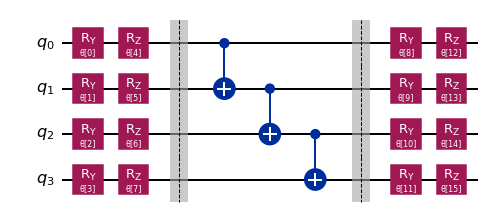

In [54]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=qubit_op_parity.num_qubits, reps=1, entanglement='linear', insert_barriers=True)

ansatz.decompose().draw('mpl', style='iqx')

In [55]:
from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(group="open")
print("Provider supports runtime: ", provider.has_service("runtime"))

backend = provider.get_backend("ibmq_qasm_simulator")

/usr/lib/python3/dist-packages/urllib3/connection.py:335: SystemTimeWarning: System time is way off (before 2019-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/usr/lib/python3/dist-packages/urllib3/connection.py:335: SystemTimeWarning: System time is way off (before 2019-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/usr/lib/python3/dist-packages/urllib3/connection.py:335: SystemTimeWarning: System time is way off (before 2019-01-01). This will probably lead to SSL verification errors
  warnings.warn(
/usr/lib/python3/dist-packages/urllib3/connection.py:335: SystemTimeWarning: System time is way off (before 2019-01-01). This will probably lead to SSL verification errors
  warnings.warn(


Provider supports runtime:  True


Now we construct a new VQE solver

In [57]:
import numpy as np
from qiskit_nature.runtime import VQEProgram
optimizer = {
    "name" : "SPSA",
    "maxiter": 50,
}
initial_point = np.random.random(ansatz.num_parameters)

runtime_vqe = VQEProgram(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True,
)

In [58]:
runtime_vqe_solver = GroundStateEigensolver(parity_converter, runtime_vqe)

In [59]:
runtime_result = runtime_vqe_solver.solve(problem_reduced)

/usr/lib/python3/dist-packages/urllib3/connection.py:335: SystemTimeWarning: System time is way off (before 2019-01-01). This will probably lead to SSL verification errors
  warnings.warn(


In [60]:
print(runtime_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -83.704391301598
  - computed part:      -1.12025536791
  - ActiveSpaceTransformer extracted energy part: -82.584135933688
~ Nuclear repulsion energy (Hartree): 9.285714221678
> Total ground state energy (Hartree): -74.41867707992
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.289 S: 0.821 S^2: 1.495 M: -0.641
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00377945]
 
  0: 
  * Electronic dipole moment (a.u.): [0.01221069  0.09252541  -0.76478646]
    - computed part:      [0.01221069  0.09252541  -1.01537802]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.25059156]
  > Dipole moment (a.u.): [-0.01221069  -0.09252541  0.76856591]  Total: 0.7742116
                 (debye): [-0.03103648  -0.23517611  1.95349949]  Total: 1.96784942
 


It is important to note that the ansatz used in this case does not conserve the number of partibles of the system, then, the number of particles change and that has to be taken into account.

# Qiskit Finance
Why finance + QC?

* Optimization:
    * Quadratic programs
        * near-term VAriational alg
        * fault tolerant
* Estimation
    * Montecarlo

### Protafolio optimization

#### Quadratic program formulation

In [ ]:
import numpy as np

mu = np.arra